<a href="https://colab.research.google.com/github/ericyoc/gan_mnist_gen_all_digits/blob/main/gan_mnist_gen_all_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [3]:
# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [4]:
# Define the training loop
@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer, cross_entropy, noise_dim):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [5]:
# Define the main function
def main():
    # Set up GPU usage
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except RuntimeError as e:
            print(e)

    # Load the MNIST dataset
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

    # Normalize the images to [-1, 1]
    train_images = (train_images - 127.5) / 127.5
    train_images = np.expand_dims(train_images, axis=-1)

    # Create a tf.data.Dataset from the training data
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Create instances of the models
    generator = make_generator_model()
    discriminator = make_discriminator_model()

    # Define the loss functions
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Define the optimizers with XLA compilation
    generator_optimizer = tf.keras.optimizers.Adam(1e-4, jit_compile=True)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, jit_compile=True)

    # Define the training parameters
    EPOCHS = 50
    noise_dim = 100
    num_examples_to_generate = 16
    seed = tf.random.normal([num_examples_to_generate, noise_dim])

    # Train the GAN
    start_time = time.time()
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        gen_loss_avg = 0
        disc_loss_avg = 0
        num_batches = 0

        for image_batch in train_dataset:
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer, cross_entropy, noise_dim)
            gen_loss_avg += gen_loss.numpy()
            disc_loss_avg += disc_loss.numpy()
            num_batches += 1

        gen_loss_avg /= num_batches
        disc_loss_avg /= num_batches

        epoch_elapsed_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{EPOCHS} - Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}, Time: {epoch_elapsed_time:.2f}s")

        # Generate and save images after every 10 epochs
        if (epoch + 1) % 10 == 0:
            generated_images = generator(seed, training=False)
            generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)

            fig = plt.figure(figsize=(4, 4))
            for i in range(generated_images.shape[0]):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.savefig(f'generated_images_epoch_{epoch+1}.png')
            plt.show()

    total_elapsed_time = time.time() - start_time
    print(f"Training completed in {total_elapsed_time:.2f}s")

Epoch 1/50 - Generator Loss: 0.8883, Discriminator Loss: 1.0463, Time: 9.89s
Epoch 2/50 - Generator Loss: 1.0433, Discriminator Loss: 1.0883, Time: 3.14s
Epoch 3/50 - Generator Loss: 0.9761, Discriminator Loss: 1.2004, Time: 3.14s
Epoch 4/50 - Generator Loss: 0.8374, Discriminator Loss: 1.2969, Time: 3.17s
Epoch 5/50 - Generator Loss: 0.9147, Discriminator Loss: 1.2212, Time: 3.14s
Epoch 6/50 - Generator Loss: 0.9724, Discriminator Loss: 1.1908, Time: 3.14s
Epoch 7/50 - Generator Loss: 1.0161, Discriminator Loss: 1.1631, Time: 3.15s
Epoch 8/50 - Generator Loss: 1.0380, Discriminator Loss: 1.1367, Time: 3.16s
Epoch 9/50 - Generator Loss: 1.1728, Discriminator Loss: 1.0834, Time: 3.17s
Epoch 10/50 - Generator Loss: 1.1443, Discriminator Loss: 1.0741, Time: 3.15s


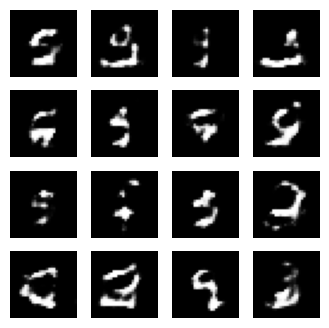

Epoch 11/50 - Generator Loss: 1.2208, Discriminator Loss: 1.0368, Time: 3.16s
Epoch 12/50 - Generator Loss: 1.1896, Discriminator Loss: 1.0458, Time: 3.15s
Epoch 13/50 - Generator Loss: 1.2117, Discriminator Loss: 1.0499, Time: 3.17s
Epoch 14/50 - Generator Loss: 1.2005, Discriminator Loss: 1.0684, Time: 3.15s
Epoch 15/50 - Generator Loss: 1.1261, Discriminator Loss: 1.1306, Time: 3.18s
Epoch 16/50 - Generator Loss: 1.0697, Discriminator Loss: 1.1644, Time: 3.14s
Epoch 17/50 - Generator Loss: 1.0316, Discriminator Loss: 1.1831, Time: 3.15s
Epoch 18/50 - Generator Loss: 1.0949, Discriminator Loss: 1.1665, Time: 3.17s
Epoch 19/50 - Generator Loss: 0.9831, Discriminator Loss: 1.2047, Time: 3.14s
Epoch 20/50 - Generator Loss: 1.0119, Discriminator Loss: 1.1997, Time: 3.13s


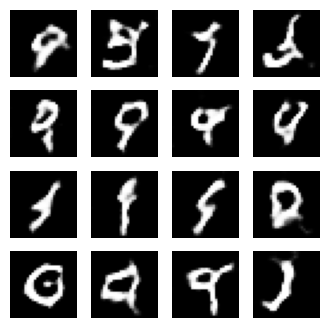

Epoch 21/50 - Generator Loss: 0.9787, Discriminator Loss: 1.2140, Time: 3.13s
Epoch 22/50 - Generator Loss: 0.9761, Discriminator Loss: 1.2083, Time: 3.15s
Epoch 23/50 - Generator Loss: 0.9512, Discriminator Loss: 1.2144, Time: 3.14s
Epoch 24/50 - Generator Loss: 0.9643, Discriminator Loss: 1.2228, Time: 3.13s
Epoch 25/50 - Generator Loss: 0.9392, Discriminator Loss: 1.2315, Time: 3.13s
Epoch 26/50 - Generator Loss: 0.9378, Discriminator Loss: 1.2295, Time: 3.14s
Epoch 27/50 - Generator Loss: 0.9553, Discriminator Loss: 1.2257, Time: 3.14s
Epoch 28/50 - Generator Loss: 1.0446, Discriminator Loss: 1.1823, Time: 3.15s
Epoch 29/50 - Generator Loss: 0.9431, Discriminator Loss: 1.2274, Time: 3.13s
Epoch 30/50 - Generator Loss: 0.9169, Discriminator Loss: 1.2406, Time: 3.14s


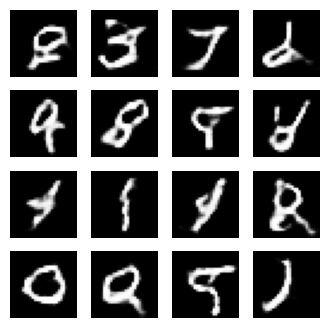

Epoch 31/50 - Generator Loss: 0.9381, Discriminator Loss: 1.2380, Time: 3.14s
Epoch 32/50 - Generator Loss: 0.9669, Discriminator Loss: 1.2267, Time: 3.14s
Epoch 33/50 - Generator Loss: 0.9122, Discriminator Loss: 1.2526, Time: 3.13s
Epoch 34/50 - Generator Loss: 0.9035, Discriminator Loss: 1.2439, Time: 3.13s
Epoch 35/50 - Generator Loss: 0.9439, Discriminator Loss: 1.2324, Time: 3.14s
Epoch 36/50 - Generator Loss: 0.9695, Discriminator Loss: 1.2284, Time: 3.15s
Epoch 37/50 - Generator Loss: 0.9282, Discriminator Loss: 1.2476, Time: 3.14s
Epoch 38/50 - Generator Loss: 0.9226, Discriminator Loss: 1.2402, Time: 3.13s
Epoch 39/50 - Generator Loss: 0.9064, Discriminator Loss: 1.2419, Time: 3.14s
Epoch 40/50 - Generator Loss: 0.9674, Discriminator Loss: 1.2256, Time: 3.15s


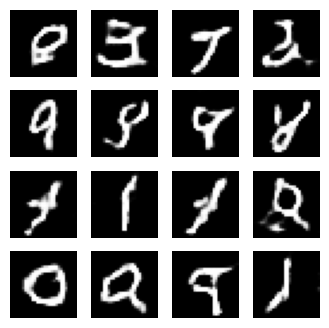

Epoch 41/50 - Generator Loss: 0.9607, Discriminator Loss: 1.2286, Time: 3.15s
Epoch 42/50 - Generator Loss: 0.9325, Discriminator Loss: 1.2325, Time: 3.14s
Epoch 43/50 - Generator Loss: 0.9327, Discriminator Loss: 1.2379, Time: 3.13s
Epoch 44/50 - Generator Loss: 0.9327, Discriminator Loss: 1.2407, Time: 3.15s
Epoch 45/50 - Generator Loss: 0.9313, Discriminator Loss: 1.2413, Time: 3.14s
Epoch 46/50 - Generator Loss: 0.9197, Discriminator Loss: 1.2470, Time: 3.14s
Epoch 47/50 - Generator Loss: 0.9061, Discriminator Loss: 1.2514, Time: 3.14s
Epoch 48/50 - Generator Loss: 0.8934, Discriminator Loss: 1.2573, Time: 3.14s
Epoch 49/50 - Generator Loss: 0.9453, Discriminator Loss: 1.2407, Time: 3.15s
Epoch 50/50 - Generator Loss: 0.9507, Discriminator Loss: 1.2380, Time: 3.17s


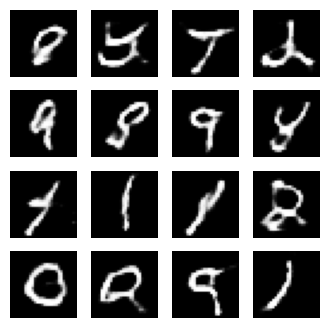

Training completed in 166.60s


In [6]:
if __name__ == '__main__':
    BATCH_SIZE = 128
    main()